# Принятие решений в бизнесе

### Постановка задачи
Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки интеренет-магазина.
Требуется приоритезировать гипотезы, запустить A/B-тест и проанализировать результаты. 

### Описание данных
#### Файл /datasets/hypothesis.csv.  
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы. 
#### Файл /datasets/orders.csv.   
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  
#### Файл /datasets/visitors.csv.  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

## Загрузка и предобработка данных

Импортируем все необходимые библиотеки

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters() 

Загрузим данные и проведем предобработку.

In [2]:
# чтение файла с данными и сохранение в hypothesis
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')

In [3]:
print(hypothesis.info())
print("Количество дубликатов:", hypothesis.duplicated().sum())
hypothesis.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
Количество дубликатов: 0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [4]:
# чтение файла с данными и сохранение в orders
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    # чтение файла с данными и сохранение в visitors
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [5]:
print(orders.info())
print("Количество дубликатов:", orders.duplicated().sum())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
Количество дубликатов: 0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
print(visitors.info())
print("Количество дубликатов:", visitors.duplicated().sum())
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
Количество дубликатов: 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
#приведем названия столбцов к соответсующему стилю:
hypothesis.columns = hypothesis.columns.str.lower() 

In [8]:
#приведём столбцы с датой к типу datetime
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d') #перевод в дату
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d') #перевод в дату

In [9]:
#приведём к нижнему регистру и добавим нужнее подчёркивание для удобства чтения
orders.columns = orders.columns.str.replace('Id', '_id') 

In [10]:
print(orders.info())
print("Количество дубликатов:", orders.duplicated().sum())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
Количество дубликатов: 0


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [11]:
print(visitors.info())
print("Количество дубликатов:", visitors.duplicated().sum())
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
Количество дубликатов: 0


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Пропущенных данных и дубликатов нет. Можно приступать к приоритезации гипотез.

## Приоритизация гипотез.

Выведем полное описание гипотез.

In [12]:
pd.options.display.max_colwidth = 150
hypothesis.hypothesis

0              Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
1                                       Запустить собственную службу доставки, что сократит срок доставки заказов
2    Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3             Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
4                                Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
5                        Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
6            Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
7                Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
8                                                         Запустить акцию, дающую скидку

In [13]:
# расчтаем по формуле (impact * confidense)/efforts 
hypothesis['ice_score'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'],2)
# выведем название гипотезы, остортиорованные по убываню ice_score
hypothesis[['hypothesis', 'ice_score']].sort_values(by='ice_score', ascending=False)  


,hypothesis,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


In [14]:
# расчтаем по формуле (impact * confidense * reach)/efforts 
hypothesis['rice_score'] = hypothesis['ice_score']* hypothesis['reach'] 
# выведем название гипотезы, остортиорованные по убываню rice_score
hypothesis[['hypothesis', 'rice_score']].sort_values(by='rice_score', ascending=False)   

,hypothesis,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Рассмотрим компоненты гипотез.

In [15]:
hypothesis.sort_values(by='ice_score', ascending=False)    

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,39.99
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,3.99
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8.96
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


"Запустить акцию, дающую скидку на товар в день рождения":  
impact и confidence - почти максимальные показатели, это не удивительно, ведь людям нравится получать подарки - это довольно очевидно, поэтому эта гипотеза так выделяется;  
efforts - средний, например, организовать рекламу, сообщающую об акции, будет не так дорого.

In [16]:
hypothesis.sort_values(by='rice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,39.99
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,8.96
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,3.99
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок":  
reach - 10 баллов. добавив форму подписки на все основные страницы - ни будет пропущен ни один пользователей, зашедший на сайт  
impact - 7 баллов. форма с подпиской совершенно новое предстовление для пользвателей сервиса, он может существенно оказать влияние  
сonfidence - 8 баллов. данная оценка была дана на основе данных эскпеортов и нет никаких оснований ей не доверять, действительно, введение подписки довольно популярно в последние время и показывает положетельное влияние на диджитал продукты  
efforts - 5 баллов. средняя оценка, добавление небольшой формы на сайт не такая большая и сложная задача для разработчка    

Видим, что с добавлением охвата пользователей, приоритезация изменилась, разберём на примере акцией со скидкой на день рождения, сейчас она занимает, только 6е место - всё потому что компонент reach - имеет только 1 балл, действительно, изменения затронет намиеньшую группу польщователей, ведь акцией можно будет воспользоваться только 1 раз в год и в определенную дату.  

Несмотря на то, что данные методы очень похожи приоритезация гипотезы в зависимости от выбора того или иного, может существенно различаться, если мы ищем гипотезу, которая охватит больший круг пользователей, то выбираем RICE, если этот компонент не так важен или не для каждой гипотезы его можно объективно оценть, то ICE.

## Анализ A/B-теста

In [17]:
#создаем массив уникальных пар значений дат и групп теста
dt_groups = orders[['date', 'group']].drop_duplicates()  

#получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dt_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg({
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dt_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({
        'date': 'max',
        'group': 'max', 
        'visitors': 'sum'
    }
    ),
    axis=1,
).sort_values(by=['date', 'group']) 

#выведем полученные таблицы на экран
display(orders_aggregated.head()) 
print('')
display(visitors_aggregated.head()) 

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [18]:
#объединям полученные таблицы по дате и группе 
cumulative_df = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
#переименум столбцы 
cumulative_df.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
] 
#выведем полученную таблицу
cumulative_df.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Построим график кумулятивной выручки по группам. 

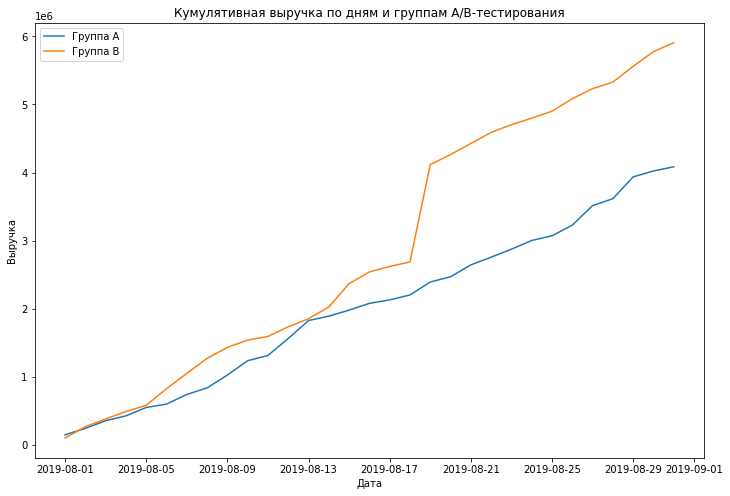

In [19]:
#зададим размеры графика 
plt.figure(figsize=(12,8))  

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_df[cumulative_df['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_df[cumulative_df['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования')
plt.show() 


Видим резкий скачок выручки группы B

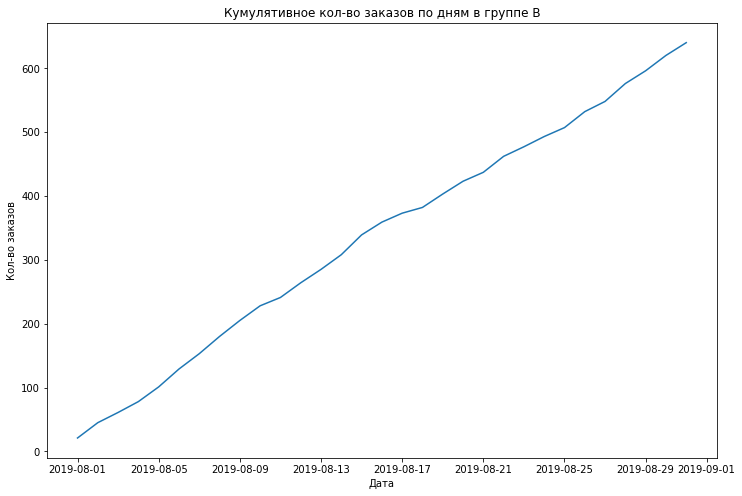

In [20]:
#зададим размеры графика 
plt.figure(figsize=(12,8)) 
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['orders'])  
# зададим описание графика
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов') 
plt.title('Кумулятивное кол-во заказов по дням в группе B')
plt.show() 

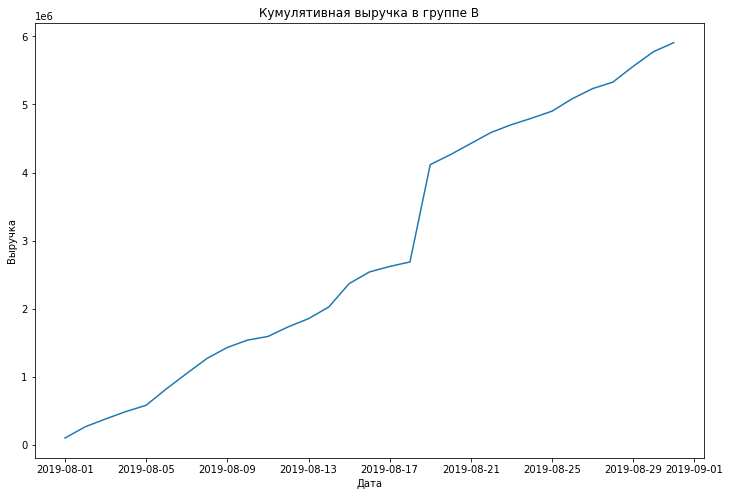

In [21]:
#зададим размеры графика 
plt.figure(figsize=(12,8)) 
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'])  
# зададим описание графика
plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.title('Кумулятивная выручка в группе B')
plt.show() 

Рост заметен на графике с выручкой, можем сделать вывод о том, что в группу попал анамально большой заказ

### Построим график кумулятивного среднего чека по группам. 

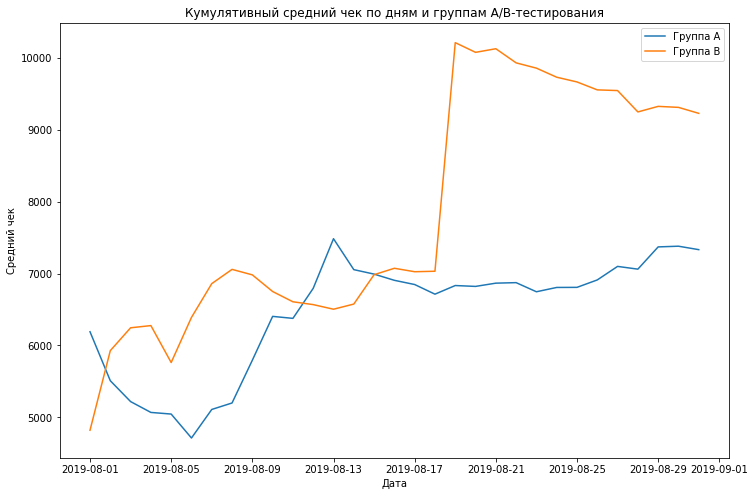

In [22]:
#зададим размеры графика  
plt.figure(figsize=(12,8))   

#построим графики, что бы получить средний чек, разделим выручку на число заказов
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()  

# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
plt.xlabel('Дата')
plt.ylabel('Средний чек') 
plt.title('Кумулятивный средний чек по дням и группам A/B-тестирования')
plt.show()  

На графиках видим:  
в первой половине теста графики ведут себя не стабильно, есть как сильные росты, так и падения  
на графике среднего чека анамальное значения для группе B в период с 08.17 по 08.21 уже более явное  
к коцу периода коммулятивный средний чек группы B, выше, чем у А, но стоит учесть, что были анамальные значения  
к концу периода у группы А есть тенденция к росту, а у B к снижению  

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [23]:
#объеденим по столбцу с датой и зададим суффиксы для каждый группы 
merged_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', right_on='date', 
    how='left',
    suffixes=['_a', '_b']
)
#выведем получившуюся таблицу
merged_revenue.head()

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


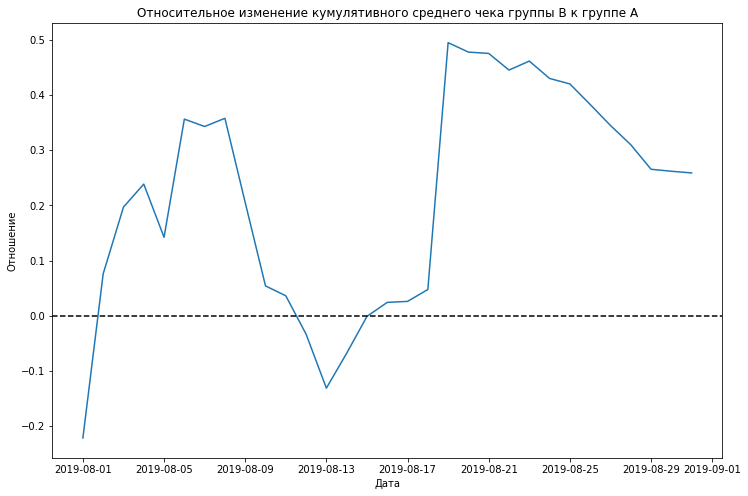

In [24]:
# зададим размеры графика  
plt.figure(figsize=(12,8))   
# cтроим отношение средних чеков
plt.plot(
    merged_revenue['date'],
    (merged_revenue['revenue_b']/
     merged_revenue['orders_b'])/
    (merged_revenue['revenue_a']/
     merged_revenue['orders_a'])
    -1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')  
# зададим описание графика 
plt.xlabel('Дата')
plt.ylabel('Отношение') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()   


На графике видим резкие скачки, это может значит, что именно в пиковый дни на графике, были сделаны анамально дорогие заказы.

### Построим график кумулятивного среднего количества заказов на посетителя по группам. 

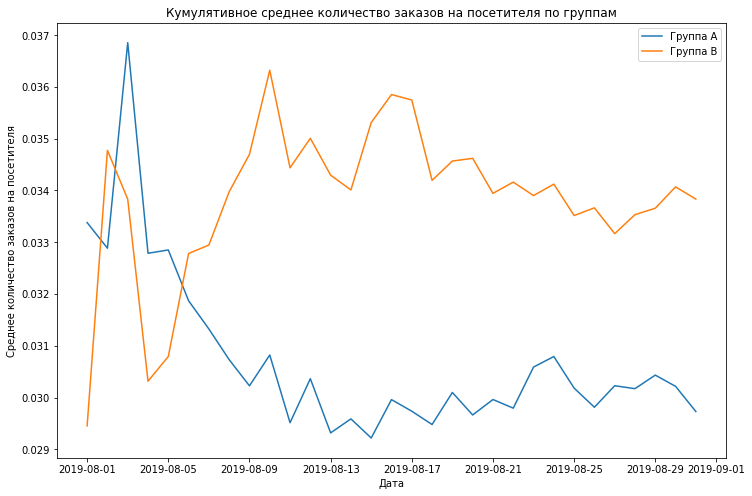

In [25]:
# считаем кумулятивное среднее количество заказов на посетителя
cumulative_df['avg_orders'] = cumulative_df['orders']/cumulative_df['visitors']

# отделяем данные по группе A
cumulative_df_a = cumulative_df[cumulative_df['group']=='A']

# отделяем данные по группе B
cumulative_df_b = cumulative_df[cumulative_df['group']=='B']

# зададим размеры графика  
plt.figure(figsize=(12,8))   

# строим графики
plt.plot(cumulative_df_a['date'], cumulative_df_a['avg_orders'], label='A')
plt.plot(cumulative_df_b['date'], cumulative_df_b['avg_orders'], label='B')


# зададим описание графика
plt.legend(['Группа А', 'Группа B']) 
# задаем масштаб осей
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя') 
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.show()  


На грфике видим, что в первые дни конверся у группы А была выше, чем у В, но спустя 6 дней со времени запуска теста, это поменялось:  

для А конверсия держалась на уровне от 0.029 до 0.031,  
для B от 0.034 до 0.036  
Предварительно гипотеза подтверждается, с новововведениями на сайте - конверсия растёт  

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

In [26]:
#объеденим по столбцу с датой и зададим суффиксы для каждый группы  
merged_сonversion = cumulative_df_a[['date','avg_orders']].merge(
    cumulative_df_b[['date','avg_orders']], 
    left_on='date',
    right_on='date', 
    how='left',
    suffixes=['_a', '_b']
)
#выведем таблицу 
merged_сonversion.head()

,date,avg_orders_a,avg_orders_b
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


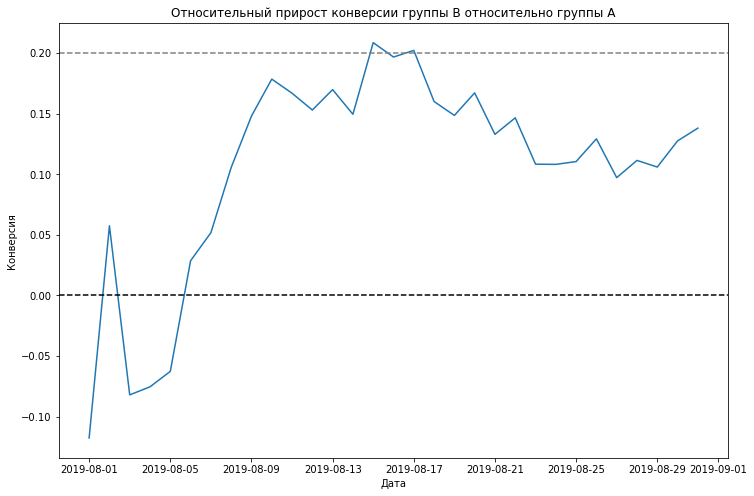

In [27]:
# зададим размеры графика  
plt.figure(figsize=(12,8))   

plt.plot(merged_сonversion['date'],
         merged_сonversion['avg_orders_b']/
         merged_сonversion['avg_orders_a']-1,
        )
# добавляем ось X c нулевым приростом и отметку в 20% 
plt.axhline(y=0, color='black', linestyle='--')  
plt.axhline(y=0.2, color='grey', linestyle='--') 
# зададим описание графика 
plt.ylabel('Конверсия') 
plt.xlabel('Дата') 
plt.title('Относительный прирост конверсии группы B относительно группы A') 
plt.show()


На графике видим, что в начале теста, конверсия показывала не стабильные результаты, сначала резко поднимаясь, а потом опускалась, но на 6й день теста, получили стабильный прирост, который привысил 20% и установился в пределах от 10 до 15 % к концу периода

### Построим точечный график количества заказов по пользователям. 

In [28]:
#создадим сводную таблицу с кол-вом закзазов для каждого пользователя 
orders_count = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
#переименуем столбуы 
orders_count.columns = ['user_id', 'orders']
#выведем таблицу отсортиованную по убыванию кол-ва заказов 
orders_count.sort_values(by='orders', ascending=False).head(10) 

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


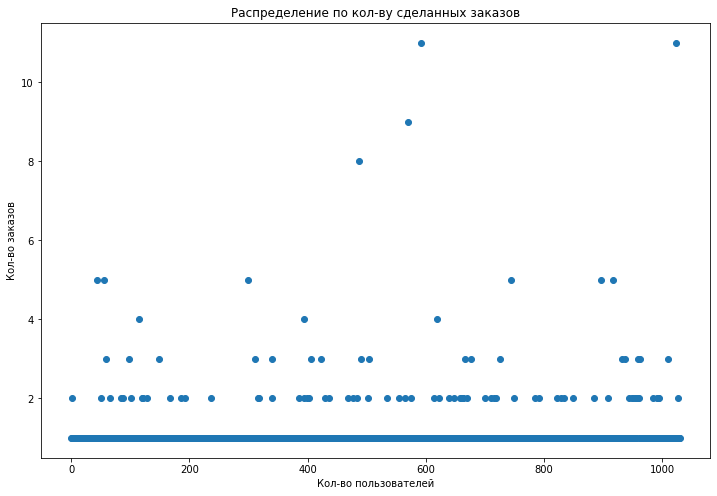

In [29]:
# серия из чисел от 0 до количества наблюдений в orders_count 
x_values = pd.Series(range(0, len(orders_count)))
# зададим размеры графика  
plt.figure(figsize=(12,8)) 
#построим график 
plt.scatter(x_values, orders_count['orders'])  
# зададим описание графика 
plt.ylabel('Кол-во заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Распределение по кол-ву сделанных заказов') 
plt.show() 

Больше всего пользователей с 1м или 2мя заказами, остальные довольно редкие, от 3х до 5 ти заказов уже можно посчитать на взгляд по кол-ву точек на графике, но есть уникальные, которые сделали до11 заказов за период.

Наверняка, на сайте есть очень активные и постоянные пользователи - это не ошибка в данных, но для создания объективного представления такие значения будут убраны

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [30]:
print(np.percentile(orders_count['orders'], [95, 99])) 

[2. 4.]


Получаем следующий результат:  

не более 5 % совершили больше 2-ух заказов  
не более 1 % совершили больше 4-ёх заказов  

Устанавливаем границу по колличеству заказов на пользователя в 3 шт., заключим её в переменную:

In [31]:
to_much_orders = np.percentile(orders_count['orders'], 95) + 1

### Построим точечный график стоимостей заказов.

In [32]:
orders[['visitor_id', 'revenue']].sort_values(by='revenue', ascending=False).head(10) 

,visitor_id,revenue
425,1920142716,1294500
1196,2108080724,202740
858,1316129916,93940
1136,1307669133,92550
744,888512513,86620
682,4266935830,78990
662,4266935830,78990
743,4133034833,67990
1103,1164614297,66350
1099,148427295,65710


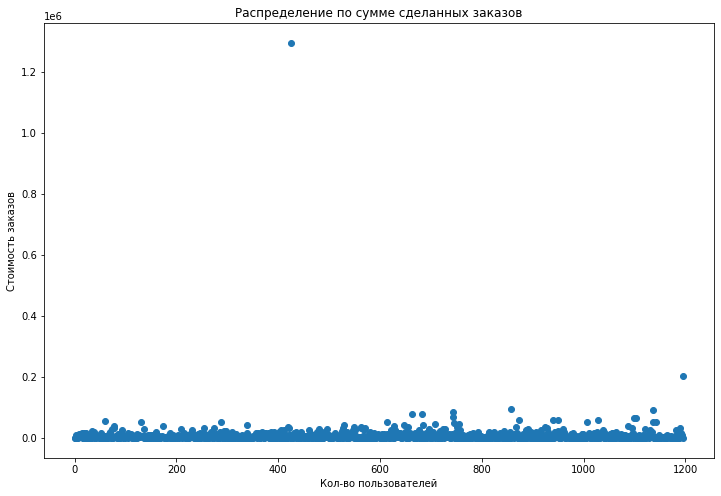

In [33]:
# серия из чисел от 0 до количества наблюдений в orders 
x_values = pd.Series(range(0, len(orders['revenue'])))
# зададим размеры графика  
plt.figure(figsize=(12,8)) 
#построим график 
scattter_plot = plt.scatter(x_values, orders['revenue'])  
# зададим описание графика 
plt.ylabel('Стоимость заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Распределение по сумме сделанных заказов') 
plt.show() 

Можно уже заметить, что максимальное значения сильно превосходит остальные. Заказы на 200 тысяч и миллинон - очевидно будут сильно выбиваться. Зададим лимит в 100 000, что бы подробнее изучить распредление наиболее частых заказов:

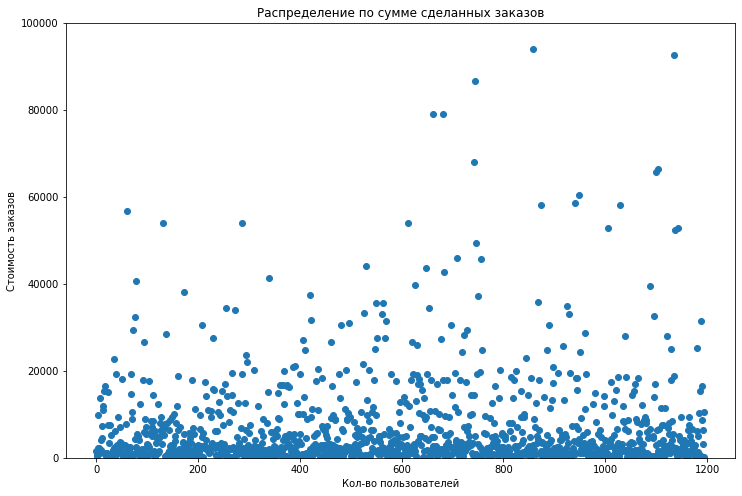

In [34]:
# серия из чисел от 0 до количества наблюдений в orders 
x_values = pd.Series(range(0, len(orders['revenue'])))
# зададим размеры графика  
plt.figure(figsize=(12,8))
#построим график 
plt.scatter(x_values, orders['revenue'])
#срежем очевидно анамальные заказы 
plt.ylim(0, 100000) 
# зададим описание графика 
plt.ylabel('Стоимость заказов') 
plt.xlabel('Кол-во пользователей') 
plt.title('Распределение по сумме сделанных заказов') 
plt.show()  


Видим, что основные значения лежат в пределах до приблизтельно 20000, по графику всё ещё сложно оценить границу анамально большого заказа, воспользуемся подсчётом процентелией

### Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов.

In [35]:
print(np.percentile(orders['revenue'], [95, 99]))  

[28000.  58233.2]


Получаем следующий результат:  

не более 5 % заказов стомостью более 28000 рублей  
не более 1 % заказов стомостью более 58000 рублей  

Устанавливаем границу по сумме заказа в 30000 рублей, добавим её в переменную:

In [36]:
to_expensive_order  = np.percentile(orders['revenue'], 95)

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

In [37]:
# таблицы с данными по заказам на каждого пользователя
orders_by_users_a = orders[orders['group']=='A'].groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_by_users_a.columns=['visitors_id','orders']

orders_by_users_b = orders[orders['group']=='B'].groupby('visitor_id')['transaction_id'].nunique().reset_index()
orders_by_users_b.columns=['visitors_id','orders'] 

display(orders_by_users_a.head()) 
display(orders_by_users_b.head())  

,visitors_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


,visitors_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [38]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(0, 
                  index=np.arange
                  (visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['orders'])
                  ),
                  name='orders'
                 )
    ],
    axis=0)
sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series
        (0,
         index=np.arange(
             visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['orders'])
         ),
         name='orders'
        )
    ],
    axis=0)

Данные для проведения теста Манна-Уитни готовы, сформируем нулевую и альетрнативную гипотезы:  

Нулевая гипотеза: Различий в среднем количестве заказов между группами нет  

Альтернативная гипотеза: Различия в среднем количестве заказов между группами есть  

Коэффициент альфа: 0.05  

In [39]:
result_1 = stats.mannwhitneyu(sample_a, sample_b)[1] 
#задаим значение aplha
alpha = 0.05
#введем значение p-value
print(f'Значение p-value : {result_1}')
# условный оператор с выводом строки с ответом
if result_1 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  
print('Среднее количество группы А: {:.1%}'.format(sample_a.mean()))
print('Среднее количество группы B: {:.1%}'.format(sample_b.mean()))  
print('Отношение средних В к А: {0:.3f}'.format(sample_b.mean()/sample_a.mean()-1))   

Значение p-value : 0.016792355056752608
Отвергаем нулевую гипотезу
Среднее количество группы А: 3.0%
Среднее количество группы B: 3.4%
Отношение средних В к А: 0.138


P-value меньше заданного значения alpha - отвергаем нулевую гипотезу, следовательно верно утвеждение о том, что различия в среднем количестве заказов есть.

Отношений конверсий группы А к В 0.138, что можно интропритировать как относительный прирост в ~13%, что является не плохим результатом, на следующих этапах посмотрим какое значения будут иметь данные без аномалий

 ### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы:  

Нулевая гипотеза: Различий в средних чеках между группами нет  

Альтернативная гипотеза: Различия в средних чеках между группами есть  

Коэффициент альфа: 0.05  

In [40]:
result_2 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]  
#введем значение p-value
print(f'Значение p-value : {result_2}')
# условный оператор с выводом строки с ответом
if result_2 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  
#выведем основные показатели
print('Средний чек группы А: {:.2f}'.format(orders[orders['group']=='A']['revenue'].mean()))
print('Средний чек группы B: {:.2f}'.format(orders[orders['group']=='B']['revenue'].mean())) 
print('Отношение между чеками A и B: {:.2f}'.format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()))  

Значение p-value : 0.7292909855432458
Не получилось отвергнуть нулевую гипотезу
Средний чек группы А: 7333.58
Средний чек группы B: 9230.88
Отношение между чеками A и B: 1.26


P-value значительно больше alpha, значит принимаем нулевую гипотезу - статичстичкой значимости различий в средних чеках нет, несмотря на разницу общего среднего значения по группам, которая составила в абсолютных значений 26%

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

In [41]:
# собираем пользователей с большим кол-вом заказов 
many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > to_much_orders]['visitors_id'],
        orders_by_users_b[orders_by_users_b['orders'] > to_much_orders]['visitors_id'],
    ],
    axis=0,
)

# собираем пользователей с слишком дорогими заказами
expensive_orders = orders[orders['revenue'] > to_expensive_order]['visitor_id']

# объединяем всё в один датафрейм 
abnormal_users = (
    pd.concat([many_orders, expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(' ')
print('Кол-во анамальных пользователей: ', abnormal_users.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
dtype: int64
 
Кол-во анамальных пользователей:  63


In [42]:
#отфильтруем данные в группе А 
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitors_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#отфильтруем данные в группе В
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitors_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)  

Сформулируем гипотезы:

Нулевая гипотеза: Различий в среднем количестве заказов между группами нет

Альтернативная гипотеза: Различия в среднем количестве заказов между группами есть

Коэффициент альфа: 0.05

In [43]:
result_3 = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1] 
#ведем значение pvalue
print(f'Значение p-value : {result_3}') 
# условный оператор с выводом строки с ответом
if result_3 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
print('Среднее количество (очищенная) группы А: {:.1%}'.format(sample_a_filtered.mean()))
print('Среднее количество (очищенная) группы B: {:.1%}'.format(sample_b_filtered.mean())) 
print('Отношение заказов В к А, по очищенным данным: {0:.3f}'.format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))  

Значение p-value : 0.017942888591552505
Отвергаем нулевую гипотезу
Среднее количество (очищенная) группы А: 2.7%
Среднее количество (очищенная) группы B: 3.0%
Отношение заказов В к А, по очищенным данным: 0.148


Для "очищенных" данных также справедливо утверждение о том, что среднеее количество заказов разные и нулевая гипотеза неверна. Само значения среднего количества заказов данных изменилось в меньшую сторону для обоих групп, лидируют по-прежнему пользователи из B, а средний прирост оказался выше на почти 2%

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сформулируем гипотезы:

Нулевая гипотеза: Различий в средних чеках между группами нет

Альтернативная гипотеза: Различия в средних чеках между группами есть

Коэффициент альфа: 0.05

In [44]:
result4 = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1] 

#посчитаем среднием значения 
mean_revenue_b = orders[np.logical_and(orders['group']=='B',
                                       np.logical_not(orders['visitor_id'].
                                                      isin(abnormal_users)))]['revenue'].mean()
mean_revenue_a = orders[np.logical_and(orders['group']=='A',
                                       np.logical_not(orders['visitor_id'].
                                                      isin(abnormal_users)))]['revenue'].mean() 

print(f'Значение p-value : {result4}')  
# условный оператор с выводом строки с ответом
if result4 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")  
#выведем всю необходимую информацию
print('Средний чек группы А (очищенная): {:.1f}'.format(mean_revenue_b))
print('Средний чек группы B (очищенная): {:.1f}'.format(mean_revenue_a))
print('Отношение средних чеков В к А, по очищенным данным: {0:.2f}'.format(mean_revenue_b / mean_revenue_a)) 

Значение p-value : 0.9765292921254219
Не получилось отвергнуть нулевую гипотезу
Средний чек группы А (очищенная): 5104.9
Средний чек группы B (очищенная): 5192.1
Отношение средних чеков В к А, по очищенным данным: 0.98


Для "очищенных" данных статистическая занчимость средних чеков группы B и A, также равны, но стоит заметить, что абсолютные значения практически выровнились, отношение близко к единице

### Решение

По результатам тестировния средний чек не изменился значительно, но среднее количетсво заказов покупателя выросло. Следует прекратить тестирование.